
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [1]:
import os
import spec_funcs as sf
import fit_funcs as ff
from filter_funcs import moving_av
from scipy.signal import fftconvolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp
import QMPlotter as qp
mp.style.use('signature.mplstyle')

path = r"C:\Users\sk88\Desktop\T1_0811"


##### Import Data  
        
        Load data sets & extract time and voltage data


In [2]:
_, file_names = sf.dir_interogate(path)
file_paths = [os.path.join(path, f_name) for f_name in file_names]
data_frames = [pd.read_csv(file_path) for file_path in file_paths]
data_lists = [[data_frame[x].values.tolist() for x in data_frame] for data_frame in data_frames]
length_data_lists = range(len(data_lists))
time_lists = [data_lists[n][0] for n in length_data_lists]
trigger_lists = [data_lists[n][1] for n in length_data_lists]
reference_lists = [data_lists[n][2] for n in length_data_lists]
transmitted_lists = [data_lists[n][3] for n in length_data_lists]


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


Text(0.5, 0, 'Time (S)')

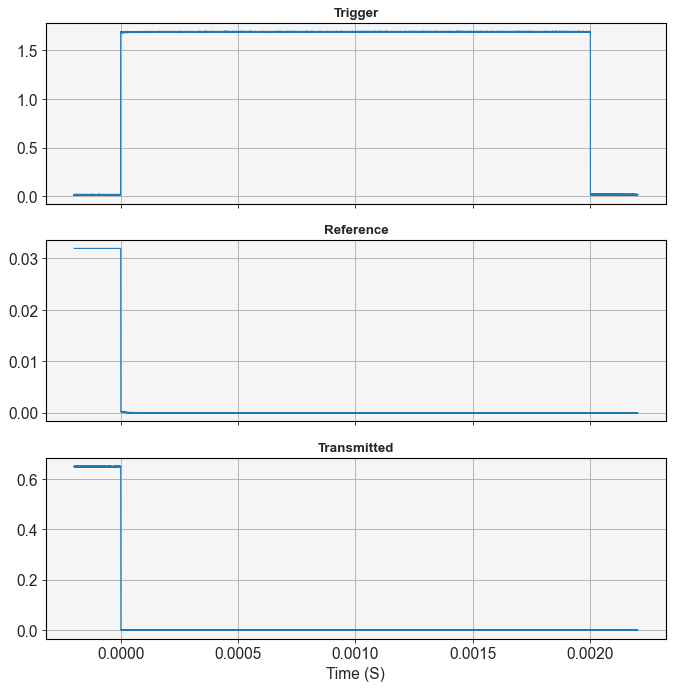

In [3]:
fig, ax = mp.subplots(nrows=3, ncols=1, sharex='all')
fig.set_figheight(10)
ax[0].set_title('Trigger')
ax[0].plot(time_lists[0], trigger_lists[0])
ax[1].set_title('Reference')
ax[1].plot(time_lists[0], reference_lists[0])
ax[2].set_title('Transmitted')
ax[2].plot(time_lists[0], transmitted_lists[0])
ax[2].set_ylabel('')
fig.add_subplot(111, frameon=False)
mp.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
mp.grid(visible=False)
mp.xlabel('Time (S)')


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

Text(0.5, 0, 'Relevant Index')

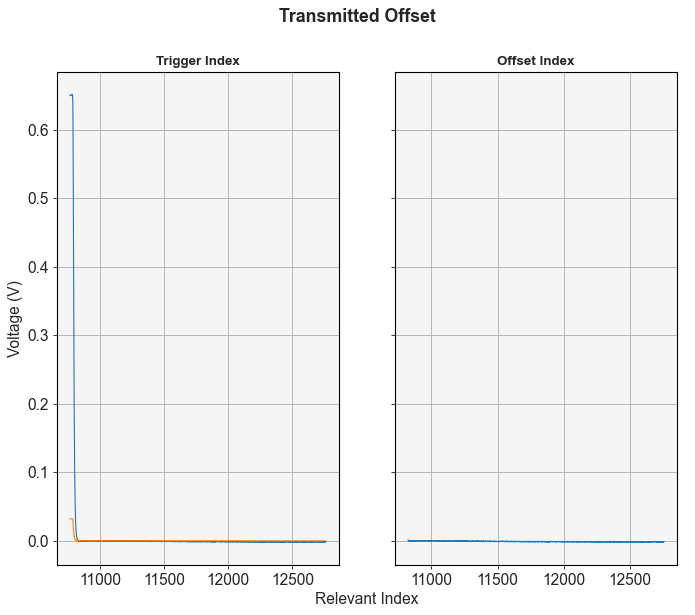

In [4]:
# find the trigger indexes
trig_indexes = [sf.find_trigger(trigger_list, np.max(trigger_list) * 0.985) for trigger_list in trigger_lists]
# plot small portion to check ramp off on transmitted data
end_index = 2000 + trig_indexes[0]
# pick an offset
offset = 60
plt_idx_trig = [x for x in range(trig_indexes[0], end_index, 1)]
plt_idx_off = [x for x in range(trig_indexes[0]+offset, end_index, 1)]
# plot the transmited data from trigger point and compare with the offset 
fig, ax = mp.subplots(ncols=2, sharey='all')
fig.suptitle('Transmitted Offset')
ax[0].set_title('Trigger Index')
ax[0].set_ylabel('Voltage (V)')
ax[0].plot(plt_idx_trig, transmitted_lists[0][trig_indexes[0]:end_index])
ax[0].plot(plt_idx_trig, reference_lists[0][trig_indexes[0]:end_index])
ax[1].set_title('Offset Index')
ax[1].plot(plt_idx_off, transmitted_lists[0][trig_indexes[0]+offset:end_index])
# add larger subplot to provide common axis label
fig.add_subplot(111, frameon=False)
mp.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
mp.grid(visible=False)
mp.xlabel('Relevant Index')


##### Process Data  

        Remove negatives and create smoothed and normalised sets


In [5]:
# generate new list of trigger indexes plus the offset
new_trig_index = [value + offset for value in trig_indexes]
# trim the data sets to only contain data from the trigger onwards
time_cut_lists = [time_list[index:-1] for time_list, index in zip(time_lists, new_trig_index)]
trans_cut_lists = [trans_list[index:-1] for trans_list, index in zip(transmitted_lists, new_trig_index)]
# find max and min values in transmitted data for list comprehension
list_of_mins = [min(trans_list) for trans_list in trans_cut_lists]
list_of_maxs = [max(trans_list) for trans_list in trans_cut_lists]
# create a boxcar window and then create a list of smoothed data
avg_window = moving_av(50)
length_avg_window = avg_window.shape[0] // 2
# create lists of smoothed, corrected, smoothed and corrected
trans_smoothed = [fftconvolve(avg_window, trans_cut_list)[length_avg_window-1:-length_avg_window] for trans_cut_list in trans_cut_lists]
trans_corrected = [[value - min for value in trans_cut_list] for trans_cut_list, min in zip(trans_cut_lists, list_of_mins)]
trans_avg_cor = [[value - min for value in trans_smooth_list] for trans_smooth_list, min in zip(trans_smoothed, list_of_mins)]

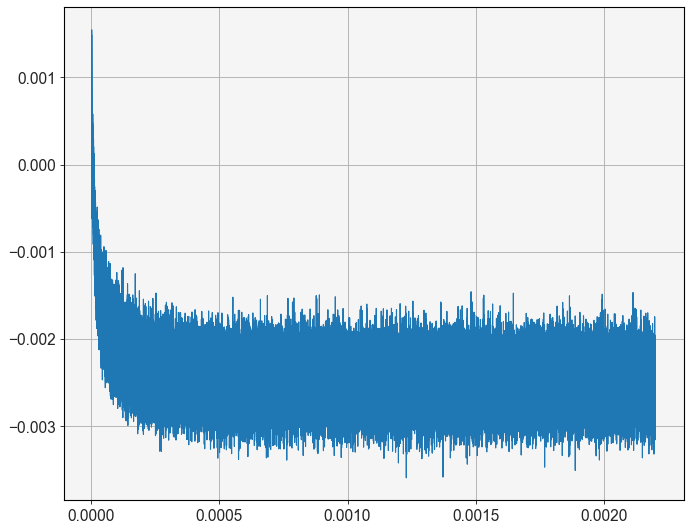

In [6]:
mp.plot(time_cut_lists[0], trans_cut_lists[0])


##### Fit To Data

        Fit to double or single exponential decay and return array of fit params and errors
      

In [7]:
# initial guess for the decay times 
guess_T = [160E-6, 50E-6]
# zip data together for list comprehension
zipped_data = zip(time_cut_lists, trans_corrected, list_of_maxs, list_of_mins)
avg_cor_data = zip(time_cut_lists, trans_avg_cor, list_of_maxs, list_of_mins)
fit_corrected = [ff.fit_dbl_exp_decay(time, trans, params=(0.6*max_val, max_val, guess_T[0], guess_T[1], min_val)) for time, trans, max_val, min_val in zipped_data]
fit_avg_cor = [ff.fit_dbl_exp_decay(time, trans, params=(0.6*max_val, max_val, guess_T[0], guess_T[1], min_val)) for time, trans, max_val, min_val in avg_cor_data]

Fit Params: 

[9.67887666e-04 1.93312398e-03 1.22006671e-04 1.54468205e-05
 1.10342323e-03]

 Fit Error: 

[2.67077360e-06 3.50824386e-06 3.11668664e-07 5.57968186e-08
 1.32066818e-07]


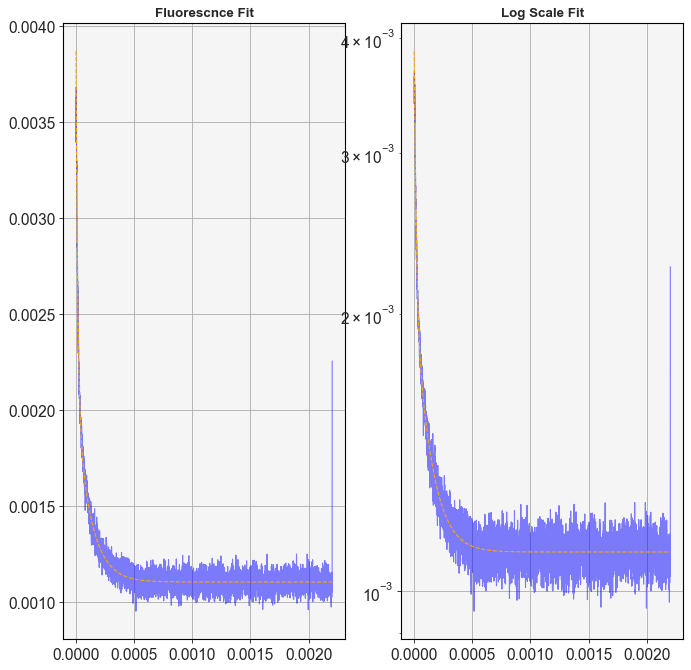

In [8]:
for int, time in enumerate(time_cut_lists):
    fig, ax = mp.subplots(nrows=1, ncols=2)
    fig.set_figheight(10)
    ax[0].set_title('Fluorescnce Fit')
    ax[0].plot(time, trans_avg_cor[int], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[int][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, trans_avg_cor[int], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[int][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    print('Fit Params: \n')
    print(fit_avg_cor[int][0])
    print('\n Fit Error: \n')
    print(fit_avg_cor[int][1])


In [9]:
# initial guess for the decay times 
guess_T = [120E-6]
# zip data together for list comprehension
zipped_data = zip(time_cut_lists, trans_corrected, list_of_maxs, list_of_mins)
avg_cor_data = zip(time_cut_lists, trans_avg_cor, list_of_maxs, list_of_mins)
fit_corrected = [ff.fit_exp_decay(time, trans, params=(0.1*max_val, guess_T[0], min_val)) for time, trans, max_val, min_val in zipped_data]
fit_avg_cor = [ff.fit_exp_decay(time, trans, params=(0.1*max_val, guess_T[0], min_val)) for time, trans, max_val, min_val in avg_cor_data]

Fit Params: 

[2.07260765e-03 5.79344189e-05 1.11568702e-03]

 Fit Error: 

[2.34377948e-06 9.34736359e-08 1.93241994e-07]


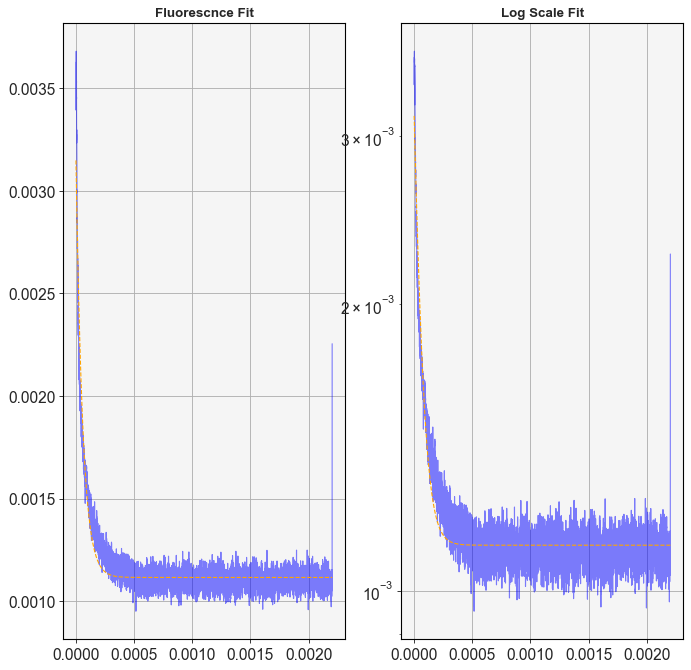

In [10]:
for int, time in enumerate(time_cut_lists):
    fig, ax = mp.subplots(nrows=1, ncols=2)
    fig.set_figheight(10)
    ax[0].set_title('Fluorescnce Fit')
    ax[0].plot(time, trans_avg_cor[int], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.exp_decay(np.array(time), *fit_avg_cor[int][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, trans_avg_cor[int], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.exp_decay(np.array(time), *fit_avg_cor[int][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    print('Fit Params: \n')
    print(fit_avg_cor[int][0])
    print('\n Fit Error: \n')
    print(fit_avg_cor[int][1])

c:\Users\sk88\Documents\Python\Spectroscopy\QMPlotter.py:61: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.
  self.ax.plot(x, y, 'x', color=self.colour, linestyle=self.linestyle,


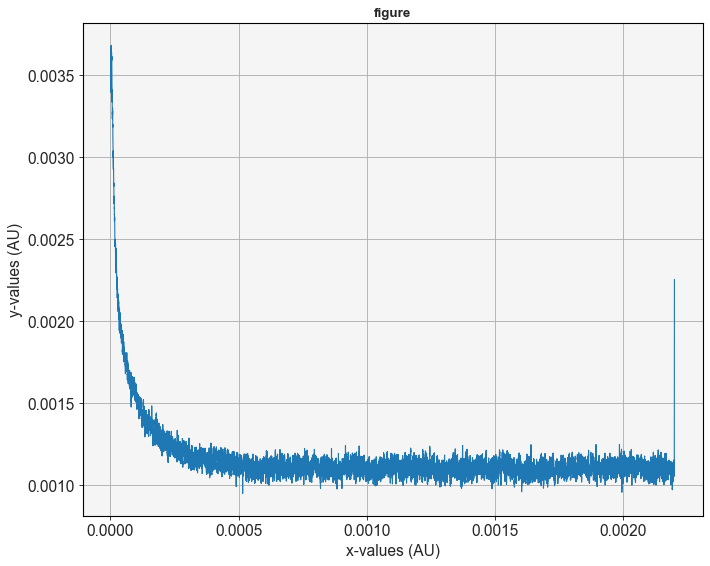

In [16]:
test = qp.plotter(time_cut_lists[0], trans_avg_cor[0])
test.display()